# Steam AU Reviews & Items

## Introduction

### Predictive task
***Given a user's past sequence of games, what is the next game they buy?***

The **input** features for our model include:
* Hours played
* Number of sessions
* Game genre
* Review text
* Basic user history

Note: Review text refers to processed user reviews through TF-IDF vectorization and analyzing sentiment scores. Basic user history refers to a user's past recommendation rate and what games already exist in their Steam library. 

The **output** of our model is a binary label (1 - recommend, 0 - not recommend) indicating whether the user recommends the game or not. This task is appropriate for supervised learning and aligns directly with models covered in the course.

### Plans: Baselines and Evaluation

We plan to use the following baseline models:
* Random baseline
* Logistic regression
* Naive Bayes

We plan to evaluate these models by comparing these metrics:
* Accuracy
* F1 score

## Imports & Setup

In [1]:
# Loading data
import gzip
import ast
from pathlib import Path

# Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Preprocessing & Splitting
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Pipelines & Feature Combos
from sklearn.pipeline import make_pipeline, FeatureUnion

# Models
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [2]:
DATA_DIR = Path('data')

def load_python_dicts_gz(path: Path, max_rows=None, verbose=True) -> pd.DataFrame:
    rows = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            rows.append(ast.literal_eval(line))
            if max_rows is not None and len(rows) >= max_rows:
                break
            if verbose and i % 100_000 == 0:
                print(f"Read {i} lines from {path.name}...")

    df = pd.json_normalize(rows)
    return df

In [3]:
# Load user reviews data
reviews_path = DATA_DIR / 'australian_user_reviews.json.gz'
reviews = load_python_dicts_gz(reviews_path, max_rows=100_000)

print('reviews shape:', reviews.shape)
print('reviews columns:')
print(list(reviews.columns))

reviews.head()

reviews shape: (25799, 3)
reviews columns:
['user_id', 'user_url', 'reviews']


,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [4]:
# Load user items data
items_path = DATA_DIR / 'australian_users_items.json.gz'
items = load_python_dicts_gz(items_path, max_rows=100)

print('items shape:', items.shape)
print('items columns:')
print(list(items.columns))

items.head()

items shape: (100, 5)
items columns:
['user_id', 'items_count', 'steam_id', 'user_url', 'items']


,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


## Preprocessing Data

### What does each value in the reviews column represent in the ``reviews`` dataframe?

In [5]:
from pprint import pprint

review_list = reviews['reviews'].iloc[0]
print(type(review_list))

pprint(review_list)

<class 'list'>
[{'funny': '',
  'helpful': 'No ratings yet',
  'item_id': '1250',
  'last_edited': '',
  'posted': 'Posted November 5, 2011.',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" '
            'hordes and team work better than left 4 dead plus has a global '
            'leveling system. Alot of down to earth "zombie" splattering fun '
            'for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'helpful': 'No ratings yet',
  'item_id': '22200',
  'last_edited': '',
  'posted': 'Posted July 15, 2011.',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'helpful': 'No ratings yet',
  'item_id': '43110',
  'last_edited': '',
  'posted': 'Posted April 21, 2011.',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at '
            'the end of the day this game is definitely worth it and I hope '
            'they 

In [6]:
first_review = review_list[0]
pprint(first_review)

{'funny': '',
 'helpful': 'No ratings yet',
 'item_id': '1250',
 'last_edited': '',
 'posted': 'Posted November 5, 2011.',
 'recommend': True,
 'review': 'Simple yet with great replayability. In my opinion does "zombie" '
           'hordes and team work better than left 4 dead plus has a global '
           'leveling system. Alot of down to earth "zombie" splattering fun '
           'for the whole family. Amazed this sort of FPS is so rare.'}


### What about the items column in the ``items`` dataframe?

In [7]:
item_list = items['items'].iloc[0]
print(type(item_list))

item_list

<class 'list'>


[{'item_id': '10',
  'item_name': 'Counter-Strike',
  'playtime_forever': 6,
  'playtime_2weeks': 0},
 {'item_id': '20',
  'item_name': 'Team Fortress Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '30',
  'item_name': 'Day of Defeat',
  'playtime_forever': 7,
  'playtime_2weeks': 0},
 {'item_id': '40',
  'item_name': 'Deathmatch Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '50',
  'item_name': 'Half-Life: Opposing Force',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '60',
  'item_name': 'Ricochet',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '70',
  'item_name': 'Half-Life',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '130',
  'item_name': 'Half-Life: Blue Shift',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '300',
  'item_name': 'Day of Defeat: Source',
  'playtime_forever': 4733,
  'playtime_2weeks': 0},
 {'item_id': '240',
  'item_name': 'Counter-Strike: S

In [8]:
first_item = item_list[0]
pprint(first_item)

{'item_id': '10',
 'item_name': 'Counter-Strike',
 'playtime_2weeks': 0,
 'playtime_forever': 6}


It seems that each value in the reviews column and items column are both lists of dictionaries. In the reviews column, each value is a dictionary of reviews for different games. In the items column, each value is a dictionary of items, or games, for different Steam users.

It's a bit hard to read each review from a user, especially if they leave a lot of reviews. We can explode the list of reviews to make it easier to read. We will also do the same thing for items.

In [9]:
# Explode list of reviews so each review gets its own row
reviews_long = reviews.explode('reviews').reset_index(drop = True)

# Split each dictionary key into separate columns
review_details = pd.json_normalize(reviews_long['reviews'])

reviews_long = pd.concat(
    [reviews_long.drop(columns = ['reviews']), review_details],
    axis = 1
)

reviews_long.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


In [10]:
items_long = items.explode("items").reset_index(drop=True)

item_details = pd.json_normalize(items_long["items"])
items_long = pd.concat(
    [items_long.drop(columns=["items"]), item_details],
    axis=1
)

items_long.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


### Explaratory Data Analysis

Now that each review and item have their own row, we can explore the data more thoroughly.

In [11]:
print("reviews_long shape:", reviews_long.shape)
print("items_long shape:", items_long.shape)

print("\nUnique users in reviews:", reviews_long["user_id"].nunique())
print("Unique users in items:",   items_long["user_id"].nunique())
print("Unique items (reviews):", reviews_long["item_id"].nunique())
print("Unique items (items):",   items_long["item_id"].nunique())

reviews_long shape: (59333, 9)
items_long shape: (10158, 8)

Unique users in reviews: 25485
Unique users in items: 100
Unique items (reviews): 3682
Unique items (items): 2758


In [12]:
reviews_per_user = reviews_long.groupby("user_id")["item_id"].nunique()
reviews_per_user.describe()

count    25485.00000
mean         2.29276
std          2.00138
min          0.00000
25%          1.00000
50%          1.00000
75%          3.00000
max         10.00000
Name: item_id, dtype: float64

In the ``reviews_per_user`` breakdown, we can see that each user leaves 2 reviews on average. The maximum number of reviews someone has left on a game is 10 while the minimum is 0.

In [13]:
owned_per_user = items_long.groupby("user_id")["item_id"].nunique()
owned_per_user.describe()

count    100.00000
mean     101.50000
std      139.67831
min        0.00000
25%       23.75000
50%       59.00000
75%      116.50000
max      888.00000
Name: item_id, dtype: float64

In the ``owned_per_user`` breakdown, we can see that users own about 101 games on average and the median number of games users own is about 59. The maximum number of games someone owns is 888 while the minimum is 0.

In [14]:
items_long["playtime_forever"].describe()

count     10150.000000
mean       1244.261379
std        7692.834643
min           0.000000
25%           0.000000
50%          56.000000
75%         374.750000
max      303466.000000
Name: playtime_forever, dtype: float64

In the ``items_long["playtime_forever"]`` breakdown, it seems that the maximum number of hours a user has spent on a game is 303,466 while the minimum is 0. On average, users have a playtime of 1244 hours and the median amount of playtime is 56 hours. With a high maximum amount of hours, it makes sense that the average is skewed to the left. It also tells us that there are users that will play the same game a lot. For users that play a variety of games, they may spend about an equal amount of time completing them (i.e 20 hours for one game, 50 hours for another game).

In [15]:
reviews_long["recommend"].value_counts(normalize=True)

recommend
True     0.884799
False    0.115201
Name: proportion, dtype: float64

Looking at this breakdown, it seems that there is an imbalance of recommended (88.48%) versus non-recommended games (11.52%). This is important to keep in mind since it can affect the performance of our model.

In [16]:
# keep only rows with an item_id
reviews_long = reviews_long.dropna(subset=["item_id"])

# parse 'posted' like "Posted November 5, 2011."
posted_clean = (
    reviews_long["posted"]
      .str.replace("Posted ", "", regex=False)
      .str.rstrip(".")
)

reviews_long["timestamp"] = pd.to_datetime(posted_clean, errors="coerce")

# drop rows we couldn't parse
reviews_long = reviews_long.dropna(subset=["timestamp"])

# sort by time per user
reviews_long = reviews_long.sort_values(["user_id", "timestamp"])
reviews_long.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,timestamp
21131,--000--,http://steamcommunity.com/id/--000--,,"Posted March 20, 2014.",,1250,1 of 1 people (100%) found this review helpful,True,หนุกคับ แนะนำ 10/10,2014-03-20
58236,--ace--,http://steamcommunity.com/id/--ace--,,"Posted January 24, 2014.",,440,2 of 3 people (67%) found this review helpful,True,the best game i ever plllayed,2014-01-24
58237,--ace--,http://steamcommunity.com/id/--ace--,,"Posted May 30, 2014.",,113200,0 of 1 people (0%) found this review helpful,True,One Of The Funnyest Games That Is Animated :) ...,2014-05-30
32158,--ionex--,http://steamcommunity.com/id/--ionex--,,"Posted August 15, 2015.",,105600,No ratings yet,True,"It's an amazing game, and im glad that mac use...",2015-08-15
45374,-2SV-vuLB-Kg,http://steamcommunity.com/id/-2SV-vuLB-Kg,,"Posted October 7, 2014.",,440,1 of 1 people (100%) found this review helpful,True,the best part of the Team Fortress 2,2014-10-07


Now that we expanded both datasets, we can combine them together into one dataframe, ``interactions``, to make it easier for analysis.

In [17]:
# make sure item_id is the same type in both tables
reviews_long["item_id"] = reviews_long["item_id"].astype(str)
items_long["item_id"]   = items_long["item_id"].astype(str)

interactions = reviews_long.merge(
    items_long[["user_id", "item_id", "item_name", "playtime_forever", "playtime_2weeks"]],
    on=["user_id", "item_id"],
    how="left"
)

interactions.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,timestamp,item_name,playtime_forever,playtime_2weeks
0,--000--,http://steamcommunity.com/id/--000--,,"Posted March 20, 2014.",,1250,1 of 1 people (100%) found this review helpful,True,หนุกคับ แนะนำ 10/10,2014-03-20,NaN,NaN,NaN
1,--ace--,http://steamcommunity.com/id/--ace--,,"Posted January 24, 2014.",,440,2 of 3 people (67%) found this review helpful,True,the best game i ever plllayed,2014-01-24,NaN,NaN,NaN
2,--ace--,http://steamcommunity.com/id/--ace--,,"Posted May 30, 2014.",,113200,0 of 1 people (0%) found this review helpful,True,One Of The Funnyest Games That Is Animated :) ...,2014-05-30,NaN,NaN,NaN
3,--ionex--,http://steamcommunity.com/id/--ionex--,,"Posted August 15, 2015.",,105600,No ratings yet,True,"It's an amazing game, and im glad that mac use...",2015-08-15,NaN,NaN,NaN
4,-2SV-vuLB-Kg,http://steamcommunity.com/id/-2SV-vuLB-Kg,,"Posted October 7, 2014.",,440,1 of 1 people (100%) found this review helpful,True,the best part of the Team Fortress 2,2014-10-07,NaN,NaN,NaN


In [18]:
(
    interactions.groupby("recommend")["playtime_forever"]
    .describe()
)

,count,mean,std,min,25%,50%,75%,max
recommend,,,,,,,,
False,4.0,208.250000,287.461737,22.0,46.75,88.0,249.5,635.0
True,71.0,11389.760563,30797.988253,20.0,589.50,1972.0,9299.0,243840.0


### Feature Engineering

With our new dataframe, we can start setting up for modeling by doing some feature engineering. The first step we have to do is drop the ``reviews`` column since our training set will be using all columns except the one we will predict. We will also be converting each value in the ``recommend`` column into an int data type.

In [19]:
# Keep essential columns: review text, playtime, target variable (is_recommended)
# Drop missing values to prevent crashes during vectorization
interactions = interactions.dropna(subset=["review"])
interactions["recommend"] = interactions["recommend"].astype(int)

interactions.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,timestamp,item_name,playtime_forever,playtime_2weeks
0,--000--,http://steamcommunity.com/id/--000--,,"Posted March 20, 2014.",,1250,1 of 1 people (100%) found this review helpful,1,หนุกคับ แนะนำ 10/10,2014-03-20,NaN,NaN,NaN
1,--ace--,http://steamcommunity.com/id/--ace--,,"Posted January 24, 2014.",,440,2 of 3 people (67%) found this review helpful,1,the best game i ever plllayed,2014-01-24,NaN,NaN,NaN
2,--ace--,http://steamcommunity.com/id/--ace--,,"Posted May 30, 2014.",,113200,0 of 1 people (0%) found this review helpful,1,One Of The Funnyest Games That Is Animated :) ...,2014-05-30,NaN,NaN,NaN
3,--ionex--,http://steamcommunity.com/id/--ionex--,,"Posted August 15, 2015.",,105600,No ratings yet,1,"It's an amazing game, and im glad that mac use...",2015-08-15,NaN,NaN,NaN
4,-2SV-vuLB-Kg,http://steamcommunity.com/id/-2SV-vuLB-Kg,,"Posted October 7, 2014.",,440,1 of 1 people (100%) found this review helpful,1,the best part of the Team Fortress 2,2014-10-07,NaN,NaN,NaN


In [20]:
# prepare data for TF-IDF

features = FeatureUnion([
    ("word_tfidf",
     TfidfVectorizer(
         max_features=50000,
         ngram_range=(1,2),
         min_df=3,
         stop_words="english",
         sublinear_tf=True
     )),
])

In [21]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(
    interactions["review"],
    interactions["recommend"],
    test_size=0.2,
    random_state=42
)

## Modeling

### Baseline models

**1) Random baseline**

Our first model is the random baseline, which is used to randomly predict either 0 or 1 based on class distribution. In the context of our dataset, it would be whether the user buys a game or not. As it is unpredictable, it is harder to beat than a majority-class baseline where there is an imbalance between buying and not buying a game, but it also ensures that our models will outperform randomness. This model also shows the value of actual machine learning models more clearly.

In [22]:
def build_baseline():
    baseline = DummyClassifier(strategy="stratified")
    baseline.fit(X_train, y_train)
    return baseline

**2) Logistic regression**

Our next model is logistic regression&mdash;a strong and widely used baseline in machine learning. We chose this baseline since it works well with high-dimensional sparse features like TF-IDF and it is also simply, interpretable, and fast to train. For our dataset, logistic regression will learn to identify a weighted linear boundary between recommend or not recommend. Its weights also correspond directly to influential words since it is able to capture the direction and strength of sentiment.

In [23]:
def build_logistic_regression():
    model = make_pipeline(
        features,
        LogisticRegression(max_iter=2000)
    )
    model.fit(X_train, y_train)
    return model

**3) Naive Bayes**

Why we included Naive Bayes

- Classic baseline for text classification tasks.

- Very fast to train and evaluate.

- Performs surprisingly well on short reviews and simple sentiment.

- Helps us check whether TF-IDF alone can produce strong performance.

What it does

- Uses word frequencies under a conditional independence assumption.

- Learns how often words appear in positive vs. negative reviews.

- Provides a lightweight benchmark to compare against more complex models.

In [24]:
def build_naive_bayes():
    text_vectorizer = TfidfVectorizer(stop_words="english")

    nb_model = make_pipeline(
        text_vectorizer,
        MultinomialNB()
    )
    nb_model.fit(X_train["review"], y_train)
    return nb_model

### Final model

**Large TF-IDF & Linear SVC**

We chose to combine these two models because Linear SVC (Support vector classifier) can perform extremely well on high-dimensional sparse text data and is more robust than Naive Bayes when there are correlating features. It can also scale better than kernel SVMs for large datasets and can quickly train tens of thousands of TF-IDF features. Additionally, it handles class imbalance well when paired with strong features. As you can recall, 88% of our dataset consists of recommended reviews and the remaining 12% are non-recommended reviews, which makes this model appropriate to use. By using the default parameter ``C=1.0``, we can prevent overfitting while still yielding a strong performance without needing any heavy tuning.

In conjunction with TF-IDF, we will use different representations together such as word-level and character-level TF-IDF to create a more expressive representation of Steam reviews. Word-level TF-IDF uses 1-2 grams that can capture simple phreases like "very fun" or "not good" while character-level TF-IDF uses 3-5 grams that can capture subword patterns which helps with misspellings, slang, and repeated letters (i.e "LET'S GOOOOO" or "so awesomee"). It can also help capture stylized writing which is common in game reviews.

By putting both models into a pipeline, we ensure that our preprocessing and model are connected. Another benefit to this is having one model for both training and prediction and that we do not need to handle features manually.

In [25]:
def build_linear_svc():
    model = make_pipeline(
        features,
        LinearSVC(C=1.0)
    )

    print("Training final LinearSVC model...")
    model.fit(X_train, y_train)
    return model

## Evaluation

Recall that our goal is to correctly predict whether a Steam user will recommend a game based on their review and gameplay behavior. Since this is a binary classification task, our evaluation needs to measure how well our model distinguishes between positive and negative recommendations.

As mentioned in the beginning of the notebook, our plans were to use the following metrics to evaluate our models:

* Accuracy

Measuring accuracy will allow us to see the percentage of correct predictions our model makes, which is useful when classes (recommend vs. not recommend) are fairly balanced.

* F1 Score

The F1 score represents the harmonic mean for precision and recall. This value is more robust than accuracy if our dataset is imbalanced, which can apply to Steam reviews.

We chose these metrics in particular due to the following reasons:
* Recommendation data often contains more positive reviews than negative ones
* Accuracy alone, especially at a high value, may be misleading for models that ignore the minority class
* F1 score captures how well the model handles both sides, making it the most appropriate metric for this type of task

Moving forward, we will be evaluating all of our models (baseline + final model) using the following helper function. In the end, we will compare our metrics in a table together to see which one scores higher.

In [26]:
def evaluate(model, name):
    '''
    Purpose: Keeps code clean and readable
             Ensures all models are evaluated consistently
    Outputs: accuracy, F1 score, ROC-AUC
    '''
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("F1 Score:", f1)

    return {
        "model": name,
        "accuracy": acc,
        "f1": f1
    }

### Baseline evaluation

In [27]:
baseline = DummyClassifier(strategy="stratified")
baseline.fit(X_train, y_train)

baseline_results = evaluate(baseline, "Baseline: Random (Stratified)")
baseline_results


=== Baseline: Random (Stratified) ===
Accuracy: 0.822728196787965
F1 Score: 0.9016023470999776


{'model': 'Baseline: Random (Stratified)',
 'accuracy': 0.822728196787965,
 'f1': 0.9016023470999776}

In [28]:
logreg_model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=300))
logreg_model.fit(X_train, y_train)

logreg_results = evaluate(logreg_model, "Logistic Regression + TF-IDF")
logreg_results


=== Logistic Regression + TF-IDF ===
Accuracy: 0.9175645456393576
F1 Score: 0.9558014060711755


{'model': 'Logistic Regression + TF-IDF',
 'accuracy': 0.9175645456393576,
 'f1': 0.9558014060711755}

In [29]:
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_model.fit(X_train, y_train)

nb_results = evaluate(nb_model, "Naive Bayes + TF-IDF")
nb_results


=== Naive Bayes + TF-IDF ===
Accuracy: 0.9016060174832283
F1 Score: 0.948246364414029


{'model': 'Naive Bayes + TF-IDF',
 'accuracy': 0.9016060174832283,
 'f1': 0.948246364414029}

### Final model evaluation

In [30]:
steam_model = make_pipeline(features, LinearSVC(C=1.0))
steam_model.fit(X_train, y_train)

svm_results = evaluate(steam_model, "Final Model: LinearSVC + TF-IDF + Numeric Features")
svm_results

C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



=== Final Model: LinearSVC + TF-IDF + Numeric Features ===
Accuracy: 0.9195974791624314
F1 Score: 0.9563682497655691


{'model': 'Final Model: LinearSVC + TF-IDF + Numeric Features',
 'accuracy': 0.9195974791624314,
 'f1': 0.9563682497655691}

### Model comparison

In [31]:
results_df = pd.DataFrame([
    baseline_results,
    nb_results,
    logreg_results,
    svm_results
])

results_df

,model,accuracy,f1
0,Baseline: Random (Stratified),0.822728,0.901602
1,Naive Bayes + TF-IDF,0.901606,0.948246
2,Logistic Regression + TF-IDF,0.917565,0.955801
3,Final Model: LinearSVC + TF-IDF + Numeric Feat...,0.919597,0.956368


### Performance plot

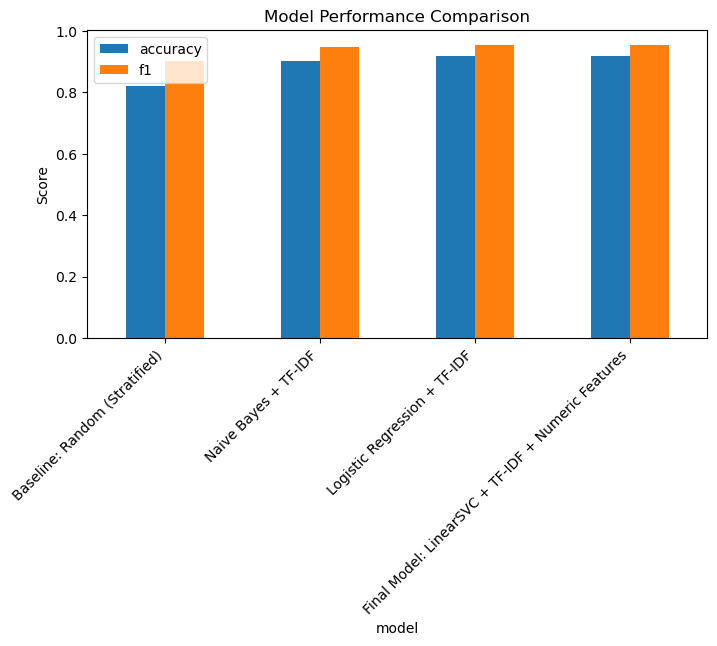

In [32]:
results_df.set_index("model")[["accuracy","f1"]].plot(kind="bar", figsize=(8,4))

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")

plt.show()

### Testing our model

***How does our model perform on unseen data?***

Here, we will grab 5% of Steam users from the full dataset to see how our model performs, allowing for quick comparison. This subset only includes the essential columns: review text, playtime, and recommendation label. We then split the data into training and testing sets (80/20) with stratification to maintain class balance.

The review text is then vectorized using a smaller TF-IDF feature set (with a maximum of 2000 features) to reduce computation time. We will also train 4 models on this subset:
* Baseline
* Logistic regression
* Naive Bayes
* LinearSVC

Like earlier, the accuracy and F1 score metrics will be evaluated for each model.

In [33]:
interactions_small = interactions.sample(frac = 0.05, random_state = 42)

print('Small subset of data being used:')
interactions_small.head()

Small subset of data being used:


,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,timestamp,item_name,playtime_forever,playtime_2weeks
14000,76561198079324079,http://steamcommunity.com/profiles/76561198079...,,"Posted January 9, 2014.",,570,No ratings yet,1,Viciante,2014-01-09,NaN,NaN,NaN
20859,ArchyRival,http://steamcommunity.com/id/ArchyRival,,"Posted October 5, 2015.",,730,0 of 1 people (0%) found this review helpful,0,♥♥♥♥ TEAM DIS GAME SUCK MAKE ME GET ♥♥♥♥ TEAM ...,2015-10-05,NaN,NaN,NaN
32133,TheMegaman96,http://steamcommunity.com/id/TheMegaman96,,"Posted April 19, 2015.",,730,No ratings yet,1,Awesome Fps Must grab game,2015-04-19,NaN,NaN,NaN
32384,TheillegalD,http://steamcommunity.com/id/TheillegalD,,"Posted June 21, 2013.",,57300,No ratings yet,1,good scary game,2013-06-21,NaN,NaN,NaN
41508,lescrepe,http://steamcommunity.com/id/lescrepe,,"Posted January 26, 2014.",,48000,No ratings yet,1,Getting stabbed in the chest by spiders has ne...,2014-01-26,NaN,NaN,NaN


In [34]:
# Extract X (review text) and y (recommendation label)
X_small = interactions_small['review']
y_small = interactions_small['recommend']

In [35]:
# train/test split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42,
    stratify=y_small
)

In [36]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words="english")

X_train_vec_s = vectorizer.fit_transform(X_train_s)
X_test_vec_s  = vectorizer.transform(X_test_s)

In [37]:
def evaluate(model, name):
    '''
    This is a helper function that both trains and evaluates a model
    '''
    model.fit(X_train_vec_s, y_train_s)
    preds = model.predict(X_test_vec_s)
    return {
        "model": name,
        "accuracy": accuracy_score(y_test_s, preds),
        "f1": f1_score(y_test_s, preds)
    }

In [38]:
print("\nTraining models...\n")

baseline_results = evaluate(
    DummyClassifier(strategy="stratified", random_state=42),
    "Baseline: Random"
)

logreg_results = evaluate(
    LogisticRegression(max_iter=500, random_state=42),
    "Logistic Regression"
)

nb_results = evaluate(
    MultinomialNB(),
    "Naive Bayes"
)

svc_results = evaluate(
    LinearSVC(C=1.0, random_state=42),
    "LinearSVC"
)

# Results table
results_small_df = pd.DataFrame([
    baseline_results,
    logreg_results,
    nb_results,
    svc_results
])

print("\nModel Performance on Small Subset:")
print(results_small_df)


Training models...


Model Performance on Small Subset:
                 model  accuracy        f1
0     Baseline: Random  0.841463  0.912360
1  Logistic Regression  0.906504  0.950959
2          Naive Bayes  0.906504  0.950959
3            LinearSVC  0.908537  0.951561


C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


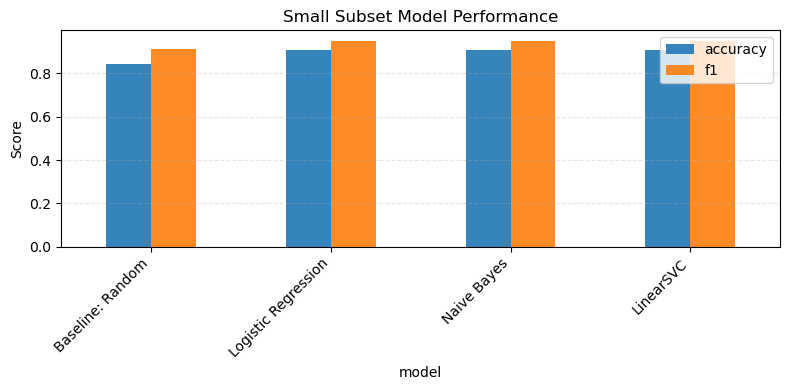

In [39]:
# Plot metrics on a bar chart
results_small_df.set_index("model")[["accuracy", "f1"]].plot(
    kind="bar",
    figsize=(8, 4),
    alpha=0.9
)

plt.title("Small Subset Model Performance")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion

The results table and performance plot summarizes the performance of all models using the same evaluation protocol. The baseline (random stratified) provides a lower bound, showing the accuracy we would expect without any real learning. Both Naive Bayes and Logistic Regression outperform this baseline by a large margin, indicating that TF-IDF features capture strong predictive signals in the review text. Our final LinearSVC model achieves the highest accuracy and F1 score, demonstrating that combining richer TF-IDF features with a stronger linear classifier provides the most effective solution for this task.

## Special Note: Next-Game Prediction Model

Besides our current model where we predicted if a user will recommend a game a not, we also tried another predictive task which we formulated as a sequential recommendation problem. Our goal here is to predict the next game a user will buy based on their game history in terms of purchases, playtime, and reviews.

Instead of predicting a binary label, this task predicts the next item in a user's lineup, making it a ranking and recommendation problem.

The **input** features for our second model include:
* Total playtime
* Total playtime in the last 2 weeks
* Game genre
* Review text

Note: Review text refers to processed user reviews through TF-IDF vectorization and analyzing sentiment scores.

We focused on these input features specifically because users who spend more hours on a game are more likely to buy similar games next, and recent playtime captures short-term interests. When looking at reviews, it can reveal user sentiment, qualitative preferences, and what kind of gameplay users value. For the model, it can detect textual patterns for certain games by capturing common key terms like "narrative-driven," "multiplayer," "open-world," etc. Genres are helpful for this task because there are users that prefer a small set of genres and genre transitions often follow predictive patterns. For instance, users who have played an RPG will play another RPG.

The **output** of our model is a game ID label which represents a single game the next user will purchase or play in a chronological sequence. This sequence is created by sorting each user's interactions by timestamp and assigning a label ``next_game`` which will be the game that comes immediately after the current one.

### Plan: Baselines and Evaluation

We plan to use the following models for this task:
* Logistic regression (one-vs-rest with TF-IDF text features)
* Naive Bayes (text-only baseline)
* Linear SVC

These models are appropriate for this task as it gives us a clear comparison between a fast, lightweight text model (Naive Bayes) and a strong linear classifier (logistic regression) which can incorporate both gameplay behavior and text information.

We plan to evaluate our model with the following metrics:
* Top-1 prediction (i.e most likely single game)
* Top-K ranking (i.e top 5 recommendations)

Since we want our predictions to be as accurate as possible, we will treat this as a multi-class classification problem where each game is a class. As such, we will use the following metrics to evaluate accuracy:
* Top-1 accuracy (i.e did the model guess the exact next game?)
* Top-K accuracy (i.e did the correct game appear in the top K predictions?)

Additionally, we will consider *precision/recall* scores to see how well our model distinguishes likely purchases.

Overall, our metrics directly measure prediction correctness as opposed to ranking quality.

### Imports & Setup

In [40]:
import ast, json, time, warnings
# import numpy as np
# import pandas as pd

# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.dummy import DummyClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC

# from sklearn.metrics import accuracy_score, f1_score

# import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

Recall that some packages are already imported for the first predictive task, which is why they are commented out here.

### Preprocessing Data

Before cleaning, we will define important constants to use.

DATA_PATH: location of reviews dataset

MIN_CLASS_COUNT: rare classes are removed if they appear lower than the given threshold

TFIDF_MAX_FEATURES: controls size of TF-IDF vocabulary

TEST_SIZE & RANDOM_STATE: ensures reproducible train/test splits

In [53]:
DATA_PATH = "data/australian_user_reviews.json"
MIN_CLASS_COUNT = 20
TFIDF_MAX_FEATURES = 30000
TEST_SIZE = 0.2
RANDOM_STATE = 42

In order to load the dataset, we will use a custom function that reads the file line-by-line. While the file is *not* valid JSON, each line is a Python dictionary literal rather than a JSON object which will be safely parsed by using ``ast.literal_eval()``. If parsing fails&mdash;usually due to quoting issues&mdash;we fall back to ``json.loads()`` after converting single quotes to double quotes. This function also skips empty lines in order to avoid malformed entries and outputs a list of user records where each record includes the following:
* ``user_id``
* ``user_url`` (if present)
* ``reviews`` (list of review dictionaries for that user)

In [42]:
def load_py_dict_lines(path):
    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            t = line.strip()
            if not t:
                continue
            try:
                records.append(ast.literal_eval(t))
            except:
                records.append(json.loads(t.replace("'", '"')))
    return records

Similar to the first predictive task, we will expand the nested reviews into a flat table so that each review gets its own row. We will put this into a function that performs the following tasks:
* Iterates through every user in the dataset
* Extracts each review inside the user's review list
* Creates one output row per review containing:
   * ``user_id``: identifies reviewer
   * ``item_id``: game being reviewed
   * ``review_text``: written review
   * ``posted``: timestamp of review

All rows are then converted into a Pandas dataframe and ready for analysis.

In [43]:
def expand_reviews(records):
    out = []
    for r in records:
        uid = r["user_id"]
        for v in r.get("reviews", []):
            out.append({
                "user_id": uid,
                "item_id": str(v.get("item_id")),
                "review_text": v.get("review", ""),
                "posted": v.get("posted")
            })
    return pd.DataFrame(out)

In our next custom function, we will preprocess our raw data and make sure it's ready for training by doing the following:

* Loads records using ``load_py_dict_lines()``
* Expands nested reviews into a flat table using ``expand_reviews()``
* Cleans timestamps by removing text like `"Posted "` and converting to `datetime`
* Remove empty reviews to ensure valid training text
* Builds sequential pairs (`current_item → next_item`) using `build_pairs()`
* Handles rare classes by merging infrequent next-item labels into `"Other"`
* Using `LabelEncoder()` so models can train on numeric classes
* Splits into train/test sets using stratified sampling for balanced evaluation

In [44]:
def load_and_prepare(sample_frac=None):
    print("Loading data...")
    records = load_py_dict_lines(DATA_PATH)
    print("Records:", len(records))

    print("Expanding...")
    df = expand_reviews(records)
    print("Rows:", len(df))

    df["posted_clean"] = (
        df["posted"].astype(str)
        .str.replace("Posted ", "", regex=False)
        .str.replace(".", "", regex=False)
    )
    df["posted_dt"] = pd.to_datetime(df["posted_clean"], errors="coerce")

    df = df[df["review_text"].astype(str).str.strip() != ""]

    print("Building pairs...")
    X_text, X_curr, y_raw = build_pairs(df)
    print("Pairs:", len(y_raw))

    # collapse rare classes
    counts = y_raw.value_counts()
    valid = counts[counts >= MIN_CLASS_COUNT].index
    y_clean = y_raw.apply(lambda x: x if x in valid else "Other")

    le = LabelEncoder()
    y = le.fit_transform(y_clean)

    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X_text, y,
        test_size=TEST_SIZE,
        stratify=y,
        random_state=RANDOM_STATE
    )

    return Xtrain, Xtest, ytrain, ytest, le

In order to train a model that can predict the *next* game a user will review, we need to convert each user's review history into ordered input-label pairs.

In this step, we will:
* Group reviews by ``user_id`` to keep each player's timeline intact
* Sort each user's reviews by timestamp (``posted_dt``)
* For users with 2+ reviews, generate sequential pairs:
   * Input: ``review_text`` of game *i*
   * Label: ``item_id`` of game *i+1*
* A sequence may look like the following:
   * review of *Game A* → next game *B*
   * review of *Game B* → next game *C*
* The function produces three aligned Series:
   * `X_text`: review text inputs  
   * `X_curr`: current game ID (optional feature)  
   * `y_next`: next game label the model must predict 

In [45]:
def build_pairs(df):
    X_text, X_curr, y_next = [], [], []

    for uid, g in df.groupby("user_id"):
        g = g.sort_values("posted_dt")

        items = g["item_id"].tolist()
        texts = g["review_text"].tolist()

        if len(items) < 2:
            continue

        for i in range(len(items) - 1):
            X_text.append(texts[i])
            X_curr.append(items[i])
            y_next.append(items[i + 1])

    return pd.Series(X_text), pd.Series(X_curr), pd.Series(y_next)

### Feature Engineering

Next, we will turn our review text into usable machine learning features by applying TF-IDF, a standard preprocessing technique.

Our function ``build_tfidf()`` will do the following:
* Transform raw text into numeric vectors that capture the importance of each word in a review
* Remove English stopwords (i.e "the" or "and) to reduce noise
* Limit vocabulary size (``max_features = 30000``) to keep training fast and memory-efficient
* Fit TF-IDF only on the training split to avoid data leaks, then transform the test split using the same vocabulary

As a result, this produces clean, high-signal text features that allow our baseline models (Naive Bayes, logistic regression, SVM) to perform well in our prediction task.

In [46]:
def build_tfidf(Xtrain, Xtest):
    print("TF-IDF...")
    tfidf = TfidfVectorizer(
        stop_words="english",
        max_features=TFIDF_MAX_FEATURES,
        ngram_range=(1, 2)    # KEEP
    )
    Xtr = tfidf.fit_transform(Xtrain)
    Xte = tfidf.transform(Xtest)
    return Xtr, Xte


### Modeling

Now that our data is ready for modeling, we will start training! We will start with the baseline model, which will:
* Provide a minimum performance benchmark
* Show how well a model performs without learning anything
* Help confirm that our real models extract signal from review text
* Accounts for class imbalance since some games may appear more than others



In [47]:
def baseline_model(Xtr, ytr):
    print("Training DummyClassifier...")
    m = DummyClassifier(strategy="most_frequent")
    m.fit(Xtr, ytr)
    return m

In [48]:
def train_logreg(Xtr, ytr):
    print("Training LogisticRegression...")
    m = LogisticRegression(
        max_iter=300,
        solver="saga",
        multi_class="multinomial",
        n_jobs=-1,
        C=2.0              # helps slightly
    )
    m.fit(Xtr, ytr)
    return m

In [49]:
def train_nb(Xtr, ytr):
    print("Training MultinomialNB...")
    m = MultinomialNB()
    m.fit(Xtr, ytr)
    return m

In [50]:
def train_svc(Xtr, ytr):
    print("Training LinearSVC...")
    m = LinearSVC()   # revert — this is important
    m.fit(Xtr, ytr)
    return m

In [51]:
def top5(model, Xte, ytrue):
    if not hasattr(model, "predict_proba"):
        return None
    probs = model.predict_proba(Xte)
    idx = np.argsort(probs, axis=1)[:, -5:]
    labels = model.classes_[idx]
    return np.mean([ytrue[i] in labels[i] for i in range(len(ytrue))])


def evaluate(model, name, Xte, ytest):
    pred = model.predict(Xte)

    acc = accuracy_score(ytest, pred)
    f1 = f1_score(ytest, pred, average="weighted")
    t5 = top5(model, Xte, ytest)

    print(f"\n{name}")
    print("accuracy:", round(acc, 4))
    print("f1:", round(f1, 4))
    print("top5:", t5)

    return acc, f1, t5

In [54]:
print("Preparing data...")
Xtrain, Xtest, ytrain, ytest, le = load_and_prepare()

Xtr, Xte = build_tfidf(Xtrain, Xtest)

results = []

# Dummy
m_dummy = baseline_model(Xtr, ytrain)
results.append(evaluate(m_dummy, "Baseline", Xte, ytest))

# Naive Bayes
m_nb = train_nb(Xtr, ytrain)
results.append(evaluate(m_nb, "Naive Bayes", Xte, ytest))

# Logistic Regression
m_lr = train_logreg(Xtr, ytrain)
results.append(evaluate(m_lr, "Logistic Regression", Xte, ytest))

# Linear SVC
m_svc = train_svc(Xtr, ytrain)
results.append(evaluate(m_svc, "LinearSVC", Xte, ytest))

print("\nDONE.")

Preparing data...
Loading data...
Records: 25799
Expanding...
Rows: 59305
Building pairs...
Pairs: 33823
TF-IDF...
Training DummyClassifier...

Baseline
accuracy: 0.2794
f1: 0.122
top5: 0.28662232076866223
Training MultinomialNB...

Naive Bayes
accuracy: 0.2792
f1: 0.122
top5: 0.39852180339985216
Training LogisticRegression...

Logistic Regression
accuracy: 0.2776
f1: 0.1248
top5: 0.3887657058388766
Training LinearSVC...

LinearSVC
accuracy: 0.1956
f1: 0.1238
top5: None

DONE.


In [55]:
df_results = pd.DataFrame(results, columns=["Accuracy", "F1 Score", "Top-5"])

df_results.index = [
    "Baseline",
    "Naive Bayes",
    "Logistic Regression",
    "Linear SVC"
]

display(df_results)

,Accuracy,F1 Score,Top-5
Baseline,0.279379,0.122017,0.286622
Naive Bayes,0.279231,0.121980,0.398522
Logistic Regression,0.277605,0.124780,0.388766
Linear SVC,0.195565,0.123824,NaN


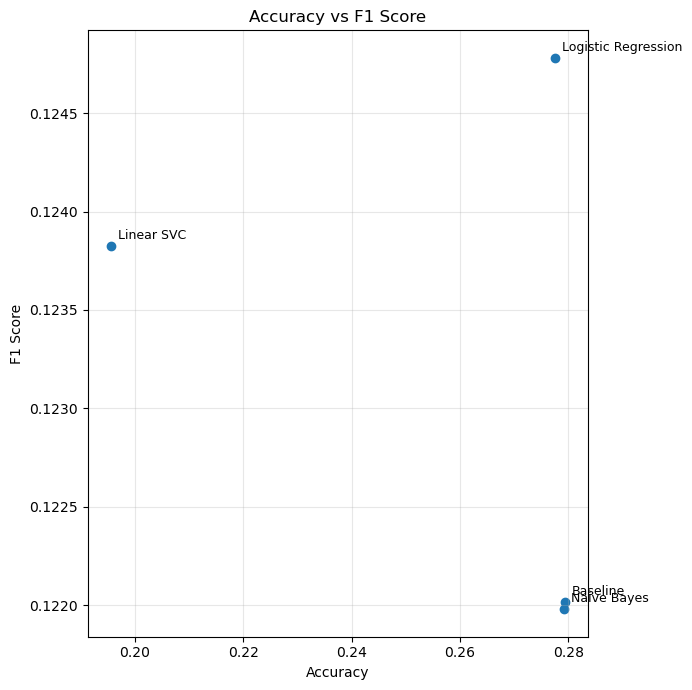

In [56]:
plt.figure(figsize=(7, 7))

plt.scatter(df_results["Accuracy"], df_results["F1 Score"])

plt.xlabel("Accuracy")
plt.ylabel("F1 Score")
plt.title("Accuracy vs F1 Score")

# Use index as model names
for model_name, row in df_results.iterrows():
    plt.annotate(
        model_name,
        (row["Accuracy"], row["F1 Score"]),
        textcoords="offset points",
        xytext=(5, 5),
        ha="left",
        fontsize=9
    )

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

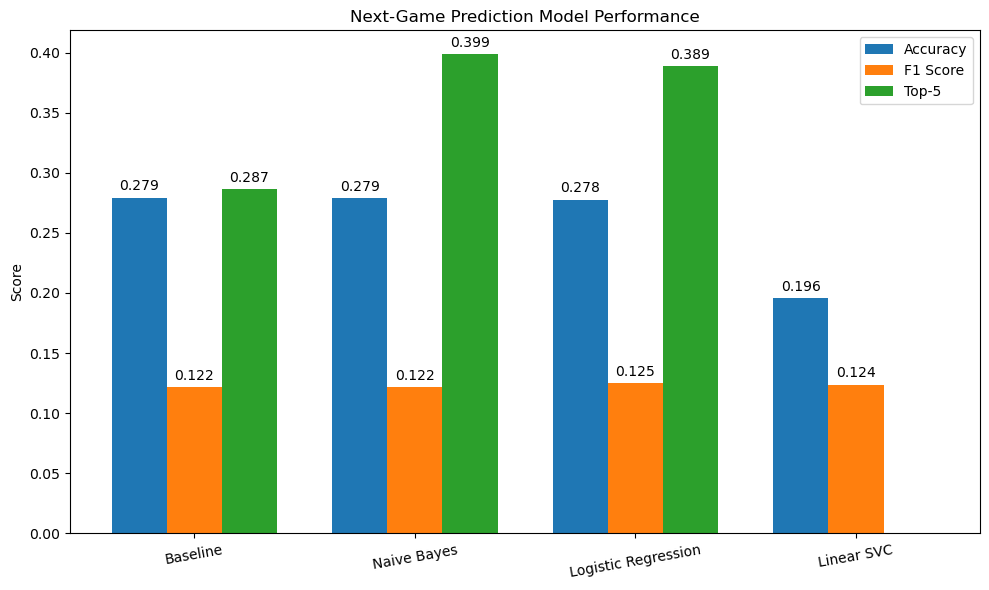

In [57]:
df_plot = df_results.reset_index().rename(columns={"index": "Model"})

metrics = ["Accuracy", "F1 Score", "Top-5"]

# Replace NaN with 0 only for plotting
df_plot[metrics] = df_plot[metrics].fillna(0)

x = np.arange(len(df_plot))  # model positions
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

bars_acc  = ax.bar(x - width, df_plot["Accuracy"], width, label="Accuracy")
bars_f1   = ax.bar(x, df_plot["F1 Score"], width, label="F1 Score")
bars_top5 = ax.bar(x + width, df_plot["Top-5"], width, label="Top-5")

# Labels & formatting
ax.set_ylabel("Score")
ax.set_title("Next-Game Prediction Model Performance")
ax.set_xticks(x)
ax.set_xticklabels(df_plot["Model"], rotation=10)
ax.legend()

# Function to label bars
def label_bars(rects):
    for r in rects:
        h = r.get_height()
        if h > 0:
            ax.annotate(f"{h:.3f}",
                        xy=(r.get_x() + r.get_width() / 2, h),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center", va="bottom")

label_bars(bars_acc)
label_bars(bars_f1)
label_bars(bars_top5)

plt.tight_layout()
plt.show()

In [58]:
import pandas as pd
import time

# ---------------------------
# 0. Load full review records
# ---------------------------
print("Loading records...")
records = load_py_dict_lines(DATA_PATH)
df_full = expand_reviews(records)
df_full["posted_clean"] = (
    df_full["posted"].astype(str)
    .str.replace("Posted ", "", regex=False)
    .str.replace(".", "", regex=False)
)
df_full["posted_dt"] = pd.to_datetime(df_full["posted_clean"], errors="coerce")

print(f"Full dataset: {len(df_full)} rows, {df_full['user_id'].nunique()} users")

# --------------------------------------
# 1. Sample 5% of users + subset reviews
# --------------------------------------
print("\nSampling 5% of users...")

users = df_full["user_id"].drop_duplicates()
sampled_users = users.sample(frac=0.05, random_state=42)

df_small = df_full[df_full["user_id"].isin(sampled_users)].copy()

print(f"5% dataset: {len(df_small)} rows, {df_small['user_id'].nunique()} users")
print(df_small.head(3))

# --------------------------
# 2. Build next–item pairs
# --------------------------
print("\nBuilding training pairs...")
start = time.time()

X_text_small, X_curr_small, y_next_small = build_pairs(df_small)

print(f"Pairs created: {len(y_next_small)}")
print(f"Time: {time.time() - start:.2f}s")

# ---------------------------------
# 3. Convert to pandas Series
# ---------------------------------
X_text_small = pd.Series(X_text_small)
y_next_small = pd.Series(y_next_small)

# ---------------------------------
# 4. Collapse rare classes
# ---------------------------------
print("\nCollapsing rare classes...")

counts = y_next_small.value_counts()
y_next_small = y_next_small.apply(
    lambda x: x if counts[x] >= 2 else "Other"
)

print(y_next_small.value_counts().head())

# ---------------------------------
# 5. Train-test split
# ---------------------------------
from sklearn.model_selection import train_test_split

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_text_small, y_next_small,
    test_size=0.2, random_state=42,
    stratify=y_next_small
)

print(f"Train: {len(X_train_s)}, Test: {len(X_test_s)}")

# ---------------------------------
# 6. Vectorize (TF-IDF)
# ---------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

print("\nTF-IDF...")
tfidf_small = TfidfVectorizer(
    stop_words='english',
    min_df=3,
    max_features=5000
)

X_train_vec_s = tfidf_small.fit_transform(X_train_s)
X_test_vec_s = tfidf_small.transform(X_test_s)

print("TF-IDF shape:", X_train_vec_s.shape)

# ---------------------------------
# 7. Train models
# ---------------------------------
from sklearn.metrics import accuracy_score, f1_score

results_small = []

def eval_model(name, preds):
    acc = accuracy_score(y_test_s, preds)
    f1 = f1_score(y_test_s, preds, average="weighted")
    results_small.append({"Model": name, "Accuracy": acc, "F1": f1})
    print(f"{name}: acc={acc:.4f}, f1={f1:.4f}")

# Baseline
print("\nRunning Baseline...")
baseline_pred = [y_train_s.mode()[0]] * len(y_test_s)
eval_model("Baseline", baseline_pred)

# Naive Bayes
print("\nRunning Naive Bayes...")
nb = MultinomialNB()
nb.fit(X_train_vec_s, y_train_s)
eval_model("Naive Bayes", nb.predict(X_test_vec_s))

# Logistic Regression
print("\nRunning Logistic Regression...")
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_vec_s, y_train_s)
eval_model("Logistic Regression", lr.predict(X_test_vec_s))

# Linear SVC
print("\nRunning Linear SVC...")
svc = LinearSVC()
svc.fit(X_train_vec_s, y_train_s)
eval_model("Linear SVC", svc.predict(X_test_vec_s))

# ---------------------------------
# 8. Results table
# ---------------------------------
results_small = pd.DataFrame(results_small)
print("\nRESULTS (5% sample):")
print(results_small)

# ---------------------------------
# 9. Prediction Showcase – DataFrame of Examples
# ---------------------------------
import numpy as np

print("\nCreating prediction showcase examples...")

def get_top5(model, vec):
    if not hasattr(model, "predict_proba"):
        return None
    p = model.predict_proba(vec)[0]
    top_idx = p.argsort()[-5:][::-1]
    return list(model.classes_[top_idx])

N = 5  # number of examples to show
ix = np.random.choice(len(X_test_s), size=N, replace=False)

rows = []
for idx in ix:
    text = X_test_s.iloc[idx]
    true_label = y_test_s.iloc[idx]
    vec = X_test_vec_s[idx]

    rows.append({
        "text": text[:150] + ("..." if len(text) > 150 else ""),
        "true": true_label,
        "baseline_pred": baseline_pred[idx],
        "nb_pred": nb.predict(vec)[0],
        "lr_pred": lr.predict(vec)[0],
        "svc_pred": svc.predict(vec)[0],
        "nb_top5": get_top5(nb, vec),
        "lr_top5": get_top5(lr, vec)
    })

pred_df = pd.DataFrame(rows)

print("\nPREDICTION SHOWCASE (sample examples):")
print(pred_df)


Loading records...
Full dataset: 59305 rows, 25458 users

Sampling 5% of users...
5% dataset: 2929 rows, 1273 users
              user_id item_id  \
49       MarbleShrine  220200   
81  76561198061252210     730   
82   OfficialShroomsy  113200   

                                          review_text  \
49  I'm going to keep this somewhat short and swee...   
81  i really do recommend anyone who has played an...   
82  Any gamer lovers of stragery and other indie g...   

                       posted       posted_clean  posted_dt  
49  Posted February 17, 2015.  February 17, 2015 2015-02-17  
81       Posted May 21, 2015.       May 21, 2015 2015-05-21  
82   Posted December 6, 2013.   December 6, 2013 2013-12-06  

Building training pairs...
Pairs created: 1656
Time: 0.42s

Collapsing rare classes...
Other     408
730        74
440        43
4000       33
218620     32
Name: count, dtype: int64
Train: 1324, Test: 332

TF-IDF...
TF-IDF shape: (1324, 1505)

Running Baseline...
Baseline

## Limitations

Despite using review text and playtime information, the overall accuracy across all models remains low. This reflects the fundamental difficulty of predicting a user’s next game—players often jump across genres, try new releases, or play games based on social influence or sales, all of which introduce randomness that the model cannot observe.

While playtime is included in the dataset, in this setup it is not directly integrated into the predictive features, so the models cannot actually learn from it. Even if it were added, raw playtime alone does not fully capture user preference—some players try games briefly, leave early reviews, or accumulate hours over years, making playtime noisy and inconsistent.

Another major limitation is the extreme class imbalance. A few games appear very frequently, while most titles appear only a handful of times. This causes the baseline predictor to look deceptively strong and makes it difficult for models to learn meaningful patterns for less common games.

Text-based TF-IDF features also limit the understanding of game similarity. The models treat each review independently and cannot detect deeper patterns in genre, mechanics, or themes. Linear SVC, while strong, cannot output probabilities, which is why its Top-5 score is missing.

## Areas for Improvement

To meaningfully boost accuracy, the model would benefit from richer, more structured information, including:

* Using playtime more effectively
  * Incorporating it as a feature or engineer signals like “long-term engagement,” “short trial,” or “review-to-playtime ratio.”
* Adding game metadata
  * Genre, tags, popularity, release year, ESRB rating, or platform would help the model recognize similarity between games.
* Using user history
  * Instead of only one review → next game, use sequences (RNN/Transformer-based recommenders like SASRec or GRU4Rec).
* Better text representations
  * Replace TF-IDF with BERT/SentenceTransformer embeddings trained on gaming content.
* Handling imbalance
  * Class weighting, oversampling, or grouping games into categories to stabilize predictions.

## Conclusion

Although we have playtime data, the current modeling setup does not fully utilize it—and even when included, predicting the next game remains a challenging, high-variance task. Improving performance will require richer user features, game-level metadata, and models tailored for sequence prediction. These changes would allow the system to capture deeper patterns in user behavior and game similarity, ultimately making next-game predictions far more reliable.